linear special 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math


def hard_sigmoid(x):
    return torch.min(torch.max(x, torch.zeros_like(x)), torch.ones_like(x))


class LinearL0Neuron(nn.Module):
    def __init__(self, origin, loc_mean=0, loc_sdev=0.01, beta=2 / 3, gamma=-0.1,
                 zeta=1.1, fix_temp=True):
        """
        Base class of layers using L0 Norm
        :param origin: original layer such as nn.Linear(..), nn.Conv2d(..)
        :param loc_mean: mean of the normal distribution which generates initial location parameters
        :param loc_sdev: standard deviation of the normal distribution which generates initial location parameters
        :param beta: initial temperature parameter
        :param gamma: lower bound of "stretched" s
        :param zeta: upper bound of "stretched" s
        :param fix_temp: True if temperature is fixed
        """
        if not isinstance(origin, nn.Linear):
            raise TypeError("This is wrapper for torch.nn.Linear layer.")
        super(LinearL0Neuron, self).__init__()
        self._origin = origin
        self._size = self._origin.out_features
        self.loc = nn.Parameter(torch.zeros(self._size).normal_(loc_mean, loc_sdev))
        self.temp = beta if fix_temp else nn.Parameter(torch.zeros(1).fill_(beta))
        self.register_buffer("uniform", torch.zeros(self._size))
        self.gamma = gamma
        self.zeta = zeta
        self.gamma_zeta_ratio = math.log(-gamma / zeta)
        self.penalty = 0

    def _get_mask(self):
        if self.training:
            self.uniform.uniform_()
            u = Variable(self.uniform)
            s = torch.sigmoid((torch.log(u) - torch.log(1 - u) + self.loc) / self.temp)
            s = s * (self.zeta - self.gamma) + self.gamma
            self.penalty = torch.sigmoid(self.loc - self.temp * self.gamma_zeta_ratio)
            self.penalty = (self.penalty * (self._origin.in_features + 1)).sum()
        else:
            s = torch.sigmoid(self.loc) * (self.zeta - self.gamma) + self.gamma
            self.penalty = 0
        return hard_sigmoid(s)
    
    def forward(self, input):
        mask = self._get_mask()
        return F.linear(input, self._origin.weight, self._origin.bias) * mask

In [2]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('..')

import numpy as np
import random
import torch

from pytorch_pretrained_bert.tokenization import BertTokenizer

from lib import data_processors, tasks
from lib.bert import BertForSequenceClassification
from lib.train_eval import train, evaluate, predict

torch.cuda.is_available()

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


True

In [3]:
# %env CUDA_VISIBLE_DEVICES=1

params = {
    'data_dir': '../../../data/SST-2', # changed
    'output_dir': '../output',
    'cache_dir': '../model_cache',
    'task_name': 'sst2',
    'bert_model': 'bert-base-uncased',
    'max_seq_length': 128,
    'train_batch_size': 12,
    'eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_proportion': 0.1,
    'num_train_epochs': 1,
    'seed': 1331,
    'device': torch.device('cuda' if torch.cuda.is_available()else 'cpu')
}

random.seed(params['seed'])
np.random.seed(params['seed'])
torch.manual_seed(params['seed'])

In [4]:
def l0_wrap_bert_layer(bert_layer):
    bert_layer.attention.self.query = LinearL0Neuron(bert_layer.attention.self.query)
    bert_layer.attention.self.key = LinearL0Neuron(bert_layer.attention.self.key)
    bert_layer.attention.self.value = LinearL0Neuron(bert_layer.attention.self.value)
    bert_layer.attention.output.dense = LinearL0Neuron(bert_layer.attention.output.dense)
    bert_layer.intermediate.dense = LinearL0Neuron(bert_layer.intermediate.dense)
    bert_layer.output.dense = LinearL0Neuron(bert_layer.output.dense)
    return bert_layer

def l0_penalty_bert_layer(bert_layer):
    penalty = 0
    for layer in bert_layer.modules():
        if isinstance(layer, LinearL0Neuron):
            penalty += layer.penalty
    return penalty

def num_zeroed(l0_linear_layer):
    n = (l0_linear_layer._get_mask().cpu().data.numpy() == 0).sum() * \
        (l0_linear_layer._origin.in_features + 1)
    return n

def num_zeroed_bert(bert_layer):
    n = 0
    for layer in bert_layer.modules():
        if isinstance(layer, LinearL0Neuron):
            n += num_zeroed(layer)
    return n

def min_element(l0_linear_layer):
    m = np.asscalar(l0_linear_layer._get_mask().min().cpu().data.numpy())
    return m

def min_element_bert(bert_layer):
    m = 1.0
    for layer in bert_layer.modules():
        if isinstance(layer, LinearL0Neuron):
            new_m = min_element(layer)
            if new_m < m:
                m = new_m
    return m

def num_params(l0_linear_layer):
    n = l0_linear_layer._origin.out_features * \
        (l0_linear_layer._origin.in_features + 1)
    return n

def num_params_bert(bert_layer):
    n = 0
    for layer in bert_layer.modules():
        if isinstance(layer, LinearL0Neuron):
            n += num_params(layer)
    return n

def all_masks_values_bert(bert_layer):
    n = 0
    arrs = []
    for layer in bert_layer.modules():
        if isinstance(layer, LinearL0Neuron):
            arrs.append(layer._get_mask().cpu().data.numpy())
    arrs = np.concatenate(arrs)
    return arrs


def matrix_rank(l0_linear_layer):
    return np.linalg.matrix_rank(
        l0_linear_layer._origin.weight.cpu().data.numpy().T *
        l0_linear_layer._get_mask().cpu().data.numpy())


def all_masks_values_bert(bert_layer):
    true_ranks = 0
    max_ranks = 0
    
    unzeroed = 0
    rows_to = 0
    for layer in bert_layer.modules():
        if isinstance(layer, LinearL0Neuron):
            true_ranks += matrix_rank(layer)
            max_ranks += min(layer._origin.weight.shape)
            
            unzeroed += (layer._get_mask().cpu().data.numpy() != 0).sum()
            rows_to += layer._origin.out_features
            
    return true_ranks / max_ranks, unzeroed / rows_to

In [5]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class PlotCallback:
    def __init__(self):
        self.min_elements = []
        self.train_loss = []
        self.eval_loss = []
        self.eval_accs = []
        
    def call_epoch(self, model, train_result, valid_result):
        clear_output()
        print('num_zeros:', num_zeroed_bert(model),
              'share:', num_zeroed_bert(model) / num_params_bert(model))
        print('rank share: {0}, rows share: {1}'.format(*all_masks_values_bert(model)))
        self.min_elements.append(min_element_bert(model))
        self.train_loss.append(train_result['train_loss'])
        self.eval_accs.append(valid_result['eval_accuracy'])
        
        plt.figure(figsize=(14, 10))
        
        plt.subplot(2, 2, 1)
        plt.hist(all_masks_values_bert(model), bins=20)
        plt.xlabel('mask value')
        plt.ylabel('num values')
        
        plt.subplot(2, 2, 2)
        plt.plot(self.min_elements)
        plt.grid(ls=":")
        plt.xlabel('num epoch')
        plt.ylabel('min element')
        
        plt.subplot(2, 2, 3)
        plt.plot(self.train_loss, label='train')
        plt.grid(ls=":")
        plt.legend()
        plt.xlabel('num epoch')
        plt.ylabel('loss')
        
        plt.subplot(2, 2, 4)
        plt.plot(self.eval_accs)
        plt.grid(ls=":")
        plt.xlabel('num epoch')
        plt.ylabel('val accuracy')
        plt.show()

In [6]:
class BertL0Encoder(nn.Module):
    def __init__(self, bert_encoder, l0_indices=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)):
        super(BertL0Encoder, self).__init__()
        self.l0_indices = l0_indices
        self.encoder = bert_encoder
        for i in self.l0_indices:
            self.encoder.layer[i] = l0_wrap_bert_layer(self.encoder.layer[i])
    
    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        penalty = 0
        for i, layer_module in enumerate(self.encoder.layer):
            hidden_states = layer_module(hidden_states, attention_mask)
            if i in self.l0_indices:
                penalty += l0_penalty_bert_layer(layer_module)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers, penalty

In [7]:
class BertL0Model(nn.Module):
    def __init__(self, bert_model):
        super(BertL0Model, self).__init__()
        self.model = bert_model
        self.model.encoder = BertL0Encoder(self.model.encoder)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.model.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.model.embeddings(input_ids, token_type_ids)
        encoded_layers, penalty = self.model.encoder(
            embedding_output,
            extended_attention_mask,
            output_all_encoded_layers=output_all_encoded_layers
        )
        sequence_output = encoded_layers[-1]
        pooled_output = self.model.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output, penalty

In [8]:
from torch.nn import CrossEntropyLoss
from lib.bert import BertForSequenceClassification

class BertL0ForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config, num_labels, l0_lambda=1):
        super(BertL0ForSequenceClassification, self).__init__(config, num_labels)
        self.l0_lambda = l0_lambda
        
    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path,
                        l0_lambda=1, state_dict=None, cache_dir=None,
                        from_tf=False, *inputs, **kwargs):
        model = super(BertL0ForSequenceClassification, cls).from_pretrained(
            pretrained_model_name_or_path, state_dict=state_dict,
            cache_dir=cache_dir, from_tf=from_tf, *inputs, **kwargs)
        model.l0_lambda = l0_lambda
        return model
    
    def wrap(self):
        self.bert = BertL0Model(self.bert)
        return self
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output, penalty = self.bert(
            input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1)) + \
                   self.l0_lambda * penalty
            return loss
        else:
            return logits

In [9]:
params['num_labels'] = tasks.num_labels[params['task_name']]
params['label_list'] = tasks.label_lists[params['task_name']]

processor = tasks.processors[params['task_name']]()
tokenizer = BertTokenizer.from_pretrained(
    params['bert_model'], do_lower_case=True)

train_examples = processor.get_train_examples(params['data_dir'])
dev_examples = processor.get_dev_examples(params['data_dir'])
model = BertL0ForSequenceClassification.from_pretrained(
    params['bert_model'],
    cache_dir=params['cache_dir'],
    num_labels=params['num_labels']).wrap().cuda()

In [10]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm_notebook
from torch.utils.data import (
    DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.modeling import BertConfig

from lib import feature_processors, metrics
from lib.bert import BertForSequenceClassification


def train(model, tokenizer, params, callback,
          train_examples,
          valid_examples=None,
          checkpoint_files={'config': 'bert_config.json',
                            'file_to_save': 'model_trained.pth'}):
    
    
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    
    train_steps_per_epoch = int(len(train_examples) / params['train_batch_size'])
    num_train_optimization_steps = train_steps_per_epoch * params['num_train_epochs']

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer
                    if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer
                    if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=params['learning_rate'],
                         warmup=params['warmup_proportion'],
                         t_total=num_train_optimization_steps)
    
    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    
    train_features = feature_processors.convert_examples_to_features(
        train_examples,
        params['label_list'],
        params['max_seq_length'],
        tokenizer)
    print("***** Running training *****")
    print("Num examples:",  len(train_examples))
    print("Batch size:  ", params['train_batch_size'])
    print("Num steps:   ", num_train_optimization_steps)
    all_input_ids = torch.tensor(
        [f.input_ids for f in train_features],
         dtype=torch.long)
    all_input_mask = torch.tensor(
        [f.input_mask for f in train_features],
         dtype=torch.long)
    all_segment_ids = torch.tensor(
        [f.segment_ids for f in train_features],
         dtype=torch.long)
    all_label_ids = torch.tensor(
        [f.label_id for f in train_features],
         dtype=torch.long)
    train_data = TensorDataset(all_input_ids,
                               all_input_mask,
                               all_segment_ids,
                               all_label_ids)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data, sampler=train_sampler,
        batch_size=params['train_batch_size'])

    model.train()
    for epoch_num in range(int(params['num_train_epochs'])):
        print('\nEpoch: {}'.format(epoch_num + 1))
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
            batch = tuple(t.to(params['device']) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss = model(input_ids, segment_ids, input_mask, label_ids)
            loss.backward()
            
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        train_result = {
            'train_loss': tr_loss / nb_tr_steps,
            'train_global_step': global_step,
        }
        
        if valid_examples is not None:
            valid_result, valid_prob_preds = evaluate(
                model, tokenizer, params, valid_examples)
            callback.call_epoch(model, train_result, valid_result)
            if (num_zeroed_bert(model) != 0):
                break
            model.train()

    if not os.path.exists(params['output_dir']):
        os.makedirs(params['output_dir'])
    model_to_save = model.module if hasattr(model, 'module') else model
    output_model_file = os.path.join(params['output_dir'],
                                     checkpoint_files['file_to_save'])
    torch.save(model_to_save.state_dict(), output_model_file)
    output_config_file = os.path.join(params['output_dir'],
                                      checkpoint_files['config'])
    with open(output_config_file, 'w') as f:
        f.write(model_to_save.config.to_json_string())

    train_result = {
        'train_loss': tr_loss / nb_tr_steps,
        'train_global_step': global_step,
    }
    
    
    return model, train_result

num_zeros: 0 share: 0.0
rank share: 0.9996202256944444, rows share: 1.0


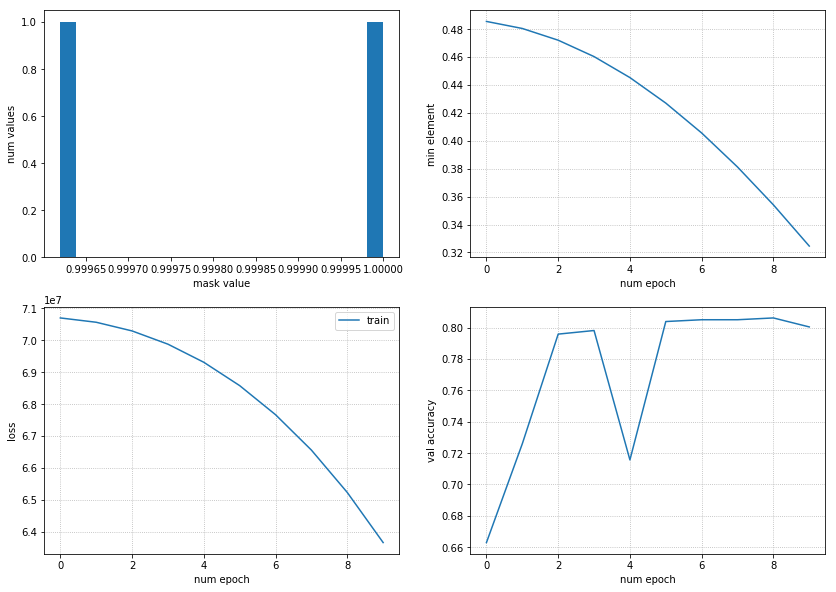


Epoch: 11


In [ ]:
EPOCH_NUM = 1

params['num_train_epochs'] = 100
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_l0_firstzero_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}
callback = PlotCallback()

model, result = train(model, tokenizer, params, callback,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result

In [20]:
plot

[70694933.58417958,
 70559830.71441297,
 70288309.41457331,
 69873623.12916444,
 69306792.47176199,
 68575756.90860502,
 67665348.44824514,
 66557369.05540709,
 65230830.43791199,
 63662484.3427757,
 61957755.781222165,
 60252981.88633529,
 58301575.59451274,
 58095836.753964014,
 57684445.87137003,
 57061418.91822555,
 56219963.35435596,
 55151687.66363798,
 53847231.506146446,
 52297192.15820417,
 50493353.64689115,
 48430297.25494388,
 46267375.93657581,
 44184651.25244967,
 42119413.70461429,
 40081329.04044183,
 38079461.7502227,
 36122056.769641906,
 34216457.48619277,
 32369685.612328522,
 30584722.33529307,
 28866745.754498485,
 27218520.420096204]

num_zeros: 69649399 share: 0.8192350642690455
rank share: 0.27249710648148145, rows share: 0.18220727237654322


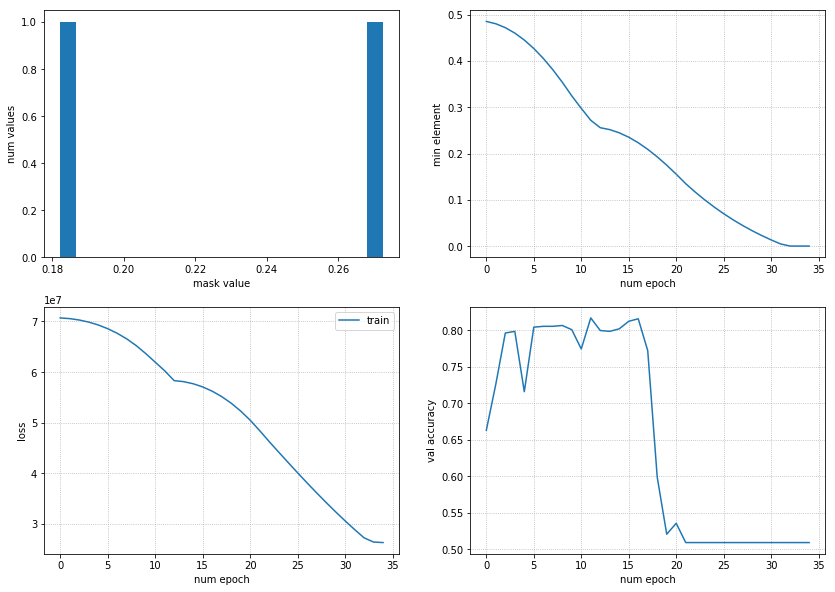

{'train_loss': 26277526.87154819, 'train_global_step': 5613}

In [23]:
EPOCH_NUM = 1

params['num_train_epochs'] = 100
checkpoint_files = {
    'config': 'bert_config.json',
    'file_to_save': 'model_l0_firstzero_{}_epoch_{}.pth'.format(
        params['task_name'], EPOCH_NUM)
}
#callback = PlotCallback()

model, result = train(model, tokenizer, params, callback,
                      train_examples,
                      valid_examples=dev_examples,
                      checkpoint_files=checkpoint_files)
result